In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt

data_dir = 'HeritageHealth/HHP_release3/'

In [2]:
# Read in data
claims = pd.read_csv(data_dir + 'Claims.csv')
members = pd.read_csv(data_dir + 'Members.csv')
drug = pd.read_csv(data_dir + 'DrugCount.csv')
lab = pd.read_csv(data_dir + 'LabCount.csv')

In [3]:
# Transform member's 'AgeAtFirstClaim' to be a numeric value
full_age = members.dropna(subset=['AgeAtFirstClaim'])
age_groups = full_age['AgeAtFirstClaim'].value_counts().index.sort_values()
ages = np.arange(len(age_groups))*10 + 5
age_map = dict(zip(age_groups, ages))
full_age = full_age.replace({'AgeAtFirstClaim': age_map})
full_age.head()

,MemberID,AgeAtFirstClaim,Sex
0,14723353,75,M
1,75706636,75,M
2,17320609,75,M
3,69690888,45,M
4,33004608,5,M


In [4]:
# Add binary column for male and females
members_ohe = pd.get_dummies(full_age, columns=["Sex"]).drop('Sex_F', axis=1)
members_ohe.head()

,MemberID,AgeAtFirstClaim,Sex_M
0,14723353,75,1
1,75706636,75,1
2,17320609,75,1
3,69690888,45,1
4,33004608,5,1


In [5]:
# Fix DrugCount type
drug['DrugCount'] = drug['DrugCount'].str.replace('7\+', '7').astype(int)
drug_by_yr = drug.groupby(['MemberID', 'Year'])[['DrugCount']].sum()
# Fix LabCount type
lab['LabCount'] = lab['LabCount'].str.replace('10\+', '10').astype(int)
lc_by_year = lab.groupby(['MemberID', 'Year'])[['LabCount']].sum()

In [6]:
# Combine Sum of LabCounts and DrugCounts
lab_drug_by_year = lc_by_year.merge(drug_by_yr, on=['MemberID', 'Year'], how='outer')
lab_drug_by_year = lab_drug_by_year.fillna(0)
lab_drug_by_year = lab_drug_by_year.reset_index()

In [7]:
# Claims DF with matched sum of LabCounts and DrugCounts for that 'Year' and 'MemberID'
# Took MemberID, PrimaryConditionGroup, LabCount, DrugCount, PlaceSvc
# Dropped columns with no PrimaryConditionGroup
cleaned_claims = claims.merge(lab_drug_by_year, on=['MemberID', 'Year'], how='left')
cleaned_claims = cleaned_claims.merge(members_ohe, on=['MemberID'], how='left')
cleaned_claims = cleaned_claims[['MemberID', 'PrimaryConditionGroup', 'PlaceSvc', 'LabCount', 'DrugCount', 'AgeAtFirstClaim', 'Sex_M']]
cleaned_claims[['LabCount', 'DrugCount']] = cleaned_claims[['LabCount', 'DrugCount']].fillna(0)
cleaned_claims = cleaned_claims.dropna(subset=['PrimaryConditionGroup', 'PlaceSvc', 'AgeAtFirstClaim', 'Sex_M'])
cleaned_claims.head()

,MemberID,PrimaryConditionGroup,PlaceSvc,LabCount,DrugCount,AgeAtFirstClaim,Sex_M
0,42286978,NEUMENT,Office,8.0,26.0,85.0,0.0
1,97903248,NEUMENT,Office,19.0,47.0,75.0,0.0
2,2759427,METAB3,Office,4.0,29.0,45.0,1.0
3,73570559,METAB3,Independent Lab,31.0,0.0,55.0,0.0
4,11837054,FXDISLC,Outpatient Hospital,10.0,41.0,85.0,0.0


In [33]:
# OHE for 'PlaceSvc'
claims_ohe = pd.get_dummies(cleaned_claims, columns=["PlaceSvc"])
claims_ohe = claims_ohe.drop('PlaceSvc_Other', axis=1)
claims_ohe.head()

,MemberID,PrimaryConditionGroup,LabCount,DrugCount,AgeAtFirstClaim,Sex_M,PlaceSvc_Ambulance,PlaceSvc_Home,PlaceSvc_Independent Lab,PlaceSvc_Inpatient Hospital,PlaceSvc_Office,PlaceSvc_Outpatient Hospital,PlaceSvc_Urgent Care
0,42286978,NEUMENT,8.0,26.0,85.0,0.0,0,0,0,0,1,0,0
1,97903248,NEUMENT,19.0,47.0,75.0,0.0,0,0,0,0,1,0,0
2,2759427,METAB3,4.0,29.0,45.0,1.0,0,0,0,0,1,0,0
3,73570559,METAB3,31.0,0.0,55.0,0.0,0,0,1,0,0,0,0
4,11837054,FXDISLC,10.0,41.0,85.0,0.0,0,0,0,0,0,1,0


In [34]:
claims_ohe.isna().sum()

MemberID                        0
PrimaryConditionGroup           0
LabCount                        0
DrugCount                       0
AgeAtFirstClaim                 0
Sex_M                           0
PlaceSvc_Ambulance              0
PlaceSvc_Home                   0
PlaceSvc_Independent Lab        0
PlaceSvc_Inpatient Hospital     0
PlaceSvc_Office                 0
PlaceSvc_Outpatient Hospital    0
PlaceSvc_Urgent Care            0
dtype: int64

In [35]:
claims_ohe.shape

(2402162, 13)

In [41]:
# Test Train Split
smaller_claims_ohe = claims_ohe[:20000]
X, y = smaller_claims_ohe.drop('PrimaryConditionGroup', axis=1), smaller_claims_ohe['PrimaryConditionGroup']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=7)

In [42]:
# SVM Multiclass Model
svm_model = svm.SVC().fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
svm_model.score(X_test, y_test)

0.2106060606060606

In [23]:
import pickle
# save the classifier
filename = 'svm_pcb_02_24_20000_rand_7.pkl'
pickle.dump(svm_model, open(filename, 'wb'))    

In [56]:
age_map.items()

dict_items([('0-9', 5), ('10-19', 15), ('20-29', 25), ('30-39', 35), ('40-49', 45), ('50-59', 55), ('60-69', 65), ('70-79', 75), ('80+', 85)])

In [70]:
age_map_df = pd.DataFrame(age_map, index=[0]).transpose().reset_index()
age_map_df = age_map_df.rename(columns={'index':'AgeAtFirstClaim', 0:'AgeApproximation'})
age_map_df

,AgeAtFirstClaim,AgeApproximation
0,0-9,5
1,10-19,15
2,20-29,25
3,30-39,35
4,40-49,45
5,50-59,55
6,60-69,65
7,70-79,75
8,80+,85


In [71]:
claims_ohe.shape

(2402162, 13)

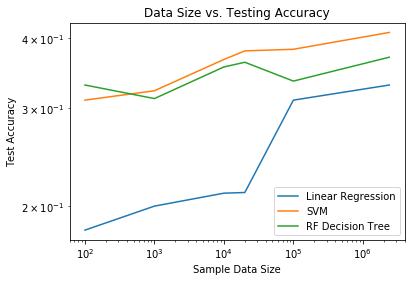

In [78]:
fig, ax = plt.subplots()
ax.set_xticks(trials)
ax.loglog()
lr = [.18111, .2, .211, .21157, .31, .33]
svm = [.31, .32225, .3667888, .37999, .38256, .4101198]
rt = [.33, .312, .3556, .36254, .3354, .37021]
trials = [100, 1000, 10000, 20000, 100000, 2402162]
plt.plot(trials, lr, label='Linear Regression')
plt.plot(trials, svm, label='SVM')
plt.plot(trials, rt, label='RF Decision Tree')
plt.xlabel('Sample Data Size')
plt.ylabel('Test Accuracy')
plt.title('Data Size vs. Testing Accuracy')
plt.legend()